<a href="https://colab.research.google.com/github/adhadse/colab_repo/blob/master/homl/Ch%2016%20Natural%20Language%20Processing%20with%20RNNs%20and%20Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 16: Natural Language Processing with RNNs and Attention
This work is partialy combined text and code from the book [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) and is only supposed to be used as reference and recommended to follow along with a copy of the Book puchased. 

We will begin the chapter with *chracter RNN*, train it to predict the next character in a sentence. 
- We will first use a *Stateless RNN* (which learns on random portions of text at each iteration, without any information on the rest of the text. 
- We will then use a *stateful RNN* (preserves the hidden state between training iterations and continuous reading where it left off).

Then we will build an RNN to perform sentiment analysis.

We will also use RNN to build an Encoder-Decoder to perform neural machine translation (NMT).

In the second part, the focus will be on *attention mechanisms*. These are Neural network components that learn to select the part of the inputs that the rest of the model should focus on at each time step. Then we look at attention only architecture called the *Transformer*.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB:
    !pip install -q -U tensorflow-addons
    !pip install -q -U transformers

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")


     |████████████████████████████████| 686kB 7.1MB/s 
     |████████████████████████████████| 2.3MB 6.8MB/s 
     |████████████████████████████████| 901kB 46.2MB/s 
     |████████████████████████████████| 3.3MB 32.3MB/s 
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Generating Shakespearean Text Using a Character RNN
Let's build a Character RNN. For that we create a Training Dataset.

## Stateless RNN
<mark>At each training iteration the model starts with a hidden state full of zeros, then it updates this state at each time step, and then it throws it away.</mark>

## Creating the Training Dataset
First, let's download all of Shakersperare's work using keras `get_file()` function.

In [ ]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
  shakespeare_text = f.read()

In [ ]:
"".join(sorted(set(shakespeare_text.lower())))

Then we will encode every character as an integer. For that we first fit `Tokenizer` on our text.

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True) # set every character to treat as token
tokenizer.fit_on_texts(shakespeare_text)

In [ ]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [ ]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [ ]:
max_id = len(tokenizer.word_index)    # number of distinct characters
max_id

39

In [ ]:
dataset_size = tokenizer.document_count # total number of characters
dataset_size

1115394

Then we'll encode the full text. 

In [ ]:
# we subtract by 1 to represent IDs from 0 to 38 
# rather than from 1 to 39
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

## How to Split a Sequential Dataset
It's often simpler to split time series across time but this assumes pattern RNN cann learn in past will still exist in the future, i.e., the time series is *stationary*.

<mark> To make sure the time series is indeed sufficiently stationary, you can plot the model's errors on the validation set across time: if the model performs much bettter on the the first part of the validations set than on the last part, then the time series may not be stationary enough, and we might need be better off training the model on a shorter time span.</mark>

Create `tf.data.Dataset` and take first 90% of the text for the training set.

In [ ]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

## Chopping the Sequential Dataset into Multiple Windows
Right now our dataset is a a very long single sequence. Feeding it to RNN will make it behave as a deep net with overr a million layers.

Using `window()` method we can convert this long sequence of characters into many smaller windows of text. Every instance in the dataset  will be fairly short substring of the whole text, making the RNN roll over the lenth of these substrings. This is called ***truncated backpropagation through time***.

> 🟢<mark>It's easier to train RNNs on shorter input sequences</mark>, but **RNN will not be able to learn any pattern longer than `n_steps`.**


In [ ]:
n_steps = 100 # length of input sequence
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, 
                         shift=1,     # By default it creates nonoverlapping windows But we wanted largest dataset possible 
                         drop_remainder=True)    # Ensures that all windows are exactly 101 characters long 
                                                 # allowing to create batches without having to do any padding


<mark>The `window()` method creates a dataset that contains windows, each of which is also represented as a dataset.</mark> This is termed as *nested dataset*.

But or model expects tensors as input, not datasets, so we need to convert it to *flat dataset* using `flat_map()`.

In [ ]:
# create a dataset from dataset of datasets
# while also converting datasets to tensors and batching them: creating a tensor for each batch

dataset = dataset.flat_map(lambda window: window.batch(window_length)) 

Since the gradient Descent works best when instances in the training set are independent and identically distributed, we <mark>shuffle the widows</mark>

In [ ]:
# A batch of 32 instances
# each tensor of length 101 encoded charaters
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)

# separate the inputs (the first 100 characters) from the target (the last character)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

Next, we encode the categorical input features as one-hot vectors. We can even do embedding but the categories are far less than 50, So.

In [ ]:
dataset = dataset.map(
    lambda X_batch, y_batch: (tf.one_hot(X_batch, depth=max_id), y_batch)
)

And add the prefetch.

In [ ]:
dataset = dataset.prefetch(1)

In [ ]:
for X_batch, Y_batch in dataset.take(1):
  print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Building and Training the Char-RNN Model


In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, 
                     input_shape=(None, max_id),
                     dropout=0.2,
                     recurrent_dropout=0.2),
    keras.layers.GRU(120, return_sequences=True,
                     dropout=0.2,
                     recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

my_checkpoint = keras.callbacks.ModelCheckpoint("Char_RNN.h5")
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=20, callbacks=[my_checkpoint])

Epoch 1/20
  21023/Unknown - 12074s 573ms/step - loss: 1.5041

## Using the Char-RNN Model
To predict the next character in text, we first need to precprocess it.

In [ ]:
def preprocess(texts):
  X = np.array(tokenizer.texts_to_sequences(texts)) - 1
  return tf.one_hot(X, max_id)

X_new = precprocess(["how are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_text(Y_pred + 1)[0][-1] # 1st sentence last character

## Generating Fake Shakespearean Text
<mark> We can pick the next character randomly, with a probability equal to the estimated probability, </mark> using `tf.random.categorical()` function.

`categorical()` function samples random class indices, give the class log probabilities (logits).

To control the diversity of character, we <mark>divide the logits by a number called  the *temperature*. 
  
Temperature close to 0, favors the high probability characters, whereas very high value give all characters an equal probability.

In [ ]:
def next_char(text, temperature): 
  X_new = preprocess([text])
  y_proba = model.predict(X_new)[0, -1, :]
  rescaled_logits = tf.math.log(y_proba) / temperature
  char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
  return tokenizer.sequences_to_text(char_id.numpy())[0]

Next, we repeatedly call `next_char()` to get the next character.

In [ ]:
def complete_text(text, n_chars=50, temperature=1):
  for _ in range(n_chars):
    text += next_char(text, temperature)
    return text

Let's generate some texts.

In [ ]:
print(complete_text("t", temperature=0.2))

In [ ]:
print(complete_text("w", temperature=1))

In [ ]:
print(complete_text("w", temperature=2))

# Stateful RNN
<mark>Stateful RNNs can preserve the final state after processing one training batch and use it as initial state for the next batch.</mark>

For that to become true, <mark>stateful RNNs require sequential and nonoverlapping input sequences.</mark>, i.e., 
- make `shift=n_steps`
- *not* call the `shuffle()` method.

Batching becomes harder as the frame will not be consecutive(to begin where it left off). One solution is to just `batch(1)`.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (window[:, :-1], windows[:, 1:]))
dataset = datset.map(
    lambda X_batch, y_batch: (tf.one_hot(X_batch, depth=max_id), y_batch)
)
dataset = dataset.prefetch(1)

When creating stateful RNN model:
- set `stateful=True` when creating every recurrent layer.
- RNN need to know the batch size, so do set `batch_input_shape` for the first layer.

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True,
                     stateful=True,
                     dropout=0.2, 
                     recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True,
                     stateful=True,
                     dropout=0.2, 
                     recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
])

At the end of each epoch, we need to reset the states before we go back to the beginning of the text. For this, we can use a small callback:

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

We'll train  it for more epochs, because each epoch is much shorter than earlier, and there is only one instance per batch).

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam")
model.fit(dataset, epochs=50, callbacks=[ResetStatesCallback()])

>🟢The trained model will require an input batches of the same size as it was trained. <mark>To uplift the restriction, create an identical *Stateless* model and copy the stateful model's weight to this model.</mark>

Now, let's do some *sentiment analysis*: using some word-level models.

# Sentiment Analysis
on IMDb reviews dataset. Let's load it.

In [ ]:
(X_train, y_train), (X_text, y_test) = keras.datasets.imdb.load_data()

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

`X_train` consists of a list of reviews, each of which is represented as a NumPy array of integers, where each integer represents a word.

The integers 0, 1, and 2 are special: they represent the padding token, the *start-of-sequences* (SSS) token, and unknown words, respectively.

In [ ]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()} # get dic with id:word with ids>=3
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
  # assign the special tokens to id 0, 1, 2
  id_to_word[id_] = token

" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

This data is already preprocessed. When you want to deploy your model to different platforms, we would want  the data to preprocessed to make predictions; for which we reuiqre to it to postable and hence usig TensorFlow operations.

Let's load the original IMDb reviews using TensorFlow Datasets.

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNQ4EM4/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNQ4EM4/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNQ4EM4/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
def preprocess(X_batch, y_batch):
  X_batch = tf.strings.substr(X_batch, pos=0, len=300)               # keep 300 char only for each
  X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")   # replace <br /> tags with spaces
  X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")   # replace any char other than letters and quote with spaces
  X_batch = tf.strings.split(X_batch)                                # split reviews by spaces; creating ragged tensor
  return X_batch.to_tensor(default_value=b"<pad>"), y_batch          # return dense tensor padding all reviews with <pad> token

**Construct Vocabulary**

Preprocess the whole training set, and use `Counter` to count the number off occurances of each word.

In [ ]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
  for review in X_batch:
    vocabulary.update(list(review.numpy()))

In [ ]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [ ]:
len(vocabulary)

53893

We probably don't require our model to know all words in the dictionary to get good performace. So let' truncate the vocabulary to only most common words.

In [ ]:
vocab_size = 10_000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]
]

Next, we'll create a lookup table to replace each word with its ID.

In [ ]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1_000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [ ]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

At last we finalize the training set to encode words, batch it and prefetch it.

In [ ]:
def encode_words(X_batch, y_batch):
  return table.lookup(X_batch), y_batch

train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

Creating the model.

In [ ]:
embedding_size = 128  # tweakable | hyperparameter
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embedding_size,
                           mask_zero=True,
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),   # The mask tensor not propagated after this, 
                             # as this layer only return output of last time step
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1408000   
_________________________________________________________________
gru_4 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,606,273
Trainable params: 1,606,273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics="accuracy")
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 122s 148ms/step - loss: 0.5379 - accuracy: 0.7236
Epoch 2/5
782/782 [==============================] - 116s 149ms/step - loss: 0.3464 - accuracy: 0.8546
Epoch 3/5
782/782 [==============================] - 116s 148ms/step - loss: 0.1886 - accuracy: 0.9330
Epoch 4/5
782/782 [==============================] - 116s 148ms/step - loss: 0.1353 - accuracy: 0.9522
Epoch 5/5
782/782 [==============================] - 113s 145ms/step - loss: 0.1155 - accuracy: 0.9578


## Masking
By simply adding `mask_zero=True` we can tell the model to ignore the padding tokens. Otherwise the model  will learn to ignore the padding tokens.

<mark>It working is that the `Embedding` layer creates *mask tensor* equal to `k.not_equal(inputs, 0)` (where `k = keras.backend`): which is a Boolean tensor with the same shape as the inputs, and it is equal to `False` anywhere the word IDs are 0 otherwie `True`.</mark> 

**This mask is then automatically propogated by the model to all subsequent layers, as long as the time dimension is preserved**.

A recurrent layer simply copies the ouput from the previous time steps whereas for the output layer (if it reaches, not in our case though) then those time steps is not contributed to the loss.

If our layer does not start with an `Embedding` layer, we might use `keras.layers.Masking` layer instead: <mark>it sets the mask to `k.any(k.not_equal(inputs, 0), axis=-1)` meaning that time steps where the last dimension is full of zeros will be masked out in subsequent layers (again, as long  as the time dimsension exits).</mark>

This masking might not work with more complex models. In such cases, you will need to explicitly compute the mask andpass it to the appropriate layers, using either the Functional API or Subclassing API.

Like in this case:



In [ ]:
# similar to previous but handles masking manually
K = keras.backend
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embedding_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)

model = keras.Model(inputs=[inputs], outputs=[outputs])

## Reusing Pretrained Embeddings
The TensorFlow Hub project makes it easy to reuse pretrained model components in your own model. These model components  are called *modules*.

These modules will be automatically downloaded, along with its prerained weights and can be easily included in your model.

We can use these *modules* like this:

In [ ]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),   # By default NOT Trainable
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 48,197,257
Trainable params: 6,657
Non-trainable params: 48,190,600
_________________________________________________________________


This *module* we just added to our model is a *Sentence encoder*. It parses the string (splitting words on spaces) and embeds each word using an emedding matrix that was trained on a huge corpus. Then it computes the mean of all the word embeddings, and the result is the sentence embedding of dimension 50.

Next, we can just load the IMDb reviews dataset, nd there is no need to preprocess it in any kind.

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].batch(batch_size).prefetch(1)
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 5s 6ms/step - loss: 0.5474 - accuracy: 0.7249
Epoch 2/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5148 - accuracy: 0.7475
Epoch 3/5
782/782 [==============================] - 4s 6ms/step - loss: 0.5092 - accuracy: 0.7508
Epoch 4/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5056 - accuracy: 0.7538
Epoch 5/5
782/782 [==============================] - 4s 5ms/step - loss: 0.5026 - accuracy: 0.7554


In [ ]:
model.evaluate(datasets["test"].batch(batch_size).prefetch(1))

782/782 [==============================] - 4s 5ms/step - loss: 0.5134 - accuracy: 0.7462


[0.5133841633796692, 0.7462400197982788]

# An Encoder-Decoder Network for Neural Machine Translation


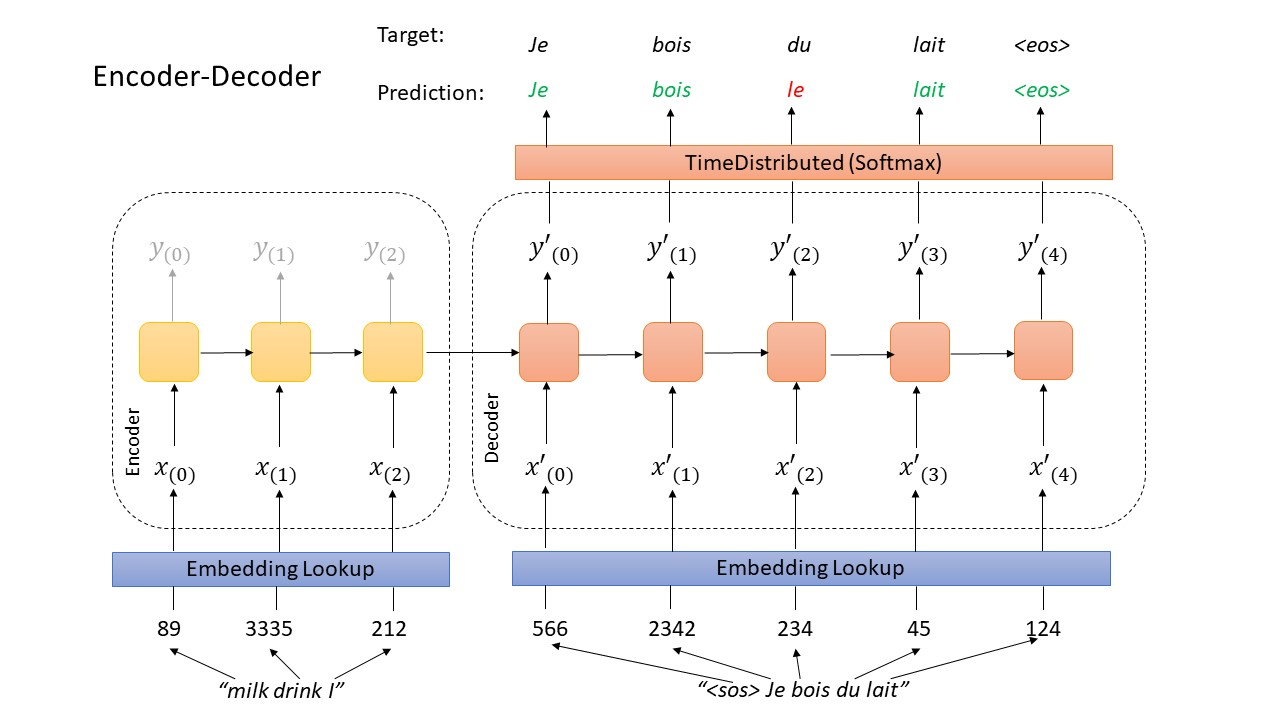

Let's say we want to create a simple neural machine translation model that will accept English sentences to French sentences.

- The encoder is given the input (embeddings of), English sentence, reversed to ensure that the beggining of the english sentence will be fed  last to the encoder, which is useful because that's generally the first thing that the decoder needs to translate.

- The decoder is given as input (embeddings of) the word that it *should* have output at the previous step.

  <mark>For the very first word it is given the start-of-sequence (SOS) token. The decoder is expected to end the sentence with an end-of-sequence (EOS) token.</mark>

<mark>At each step, the decoder outputs a score for each word in the output vocabulary (i.e., French), and then the softmax layer turns these scores into probabilities. The word with the highest probability is output.</mark>

Although at inference time, we only feed the decoder the word it outputs at the previous step.

Couple of details:
- Sentences length might vary. Group sentences according to buckets of similar length, then use padding for shorter sequences to ensure all sentences in a bucket have the same length.
- We must mask out any output past the EOS token, so that those output does not contribute to the loss.
- Outputting a probability for each and every possible word would be slow. Use *sampled softmax* technique: use only logits output by the model for the correct word and for random saample of incorrect words, then compute an apprximation of the loss based only on these logits. Use the normal softmax function at inference time.


In [4]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 6.5MB/s 


In [5]:
# A basic encoder-decoder model similar to the diagram above
import tensorflow_addons as tfa

vocab_size = 10_000
embedding_size = 128 
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embedding_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

decoder_cell = keras.layers.LSTMCell(512)
sampler = tfa.seq2seq.sampler.TrainingSampler()
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    cell=decoder_cell, 
    sampler=sampler,
    output_layer=output_layer)
final_outputs, final_state, final_sequence_length =decoder(
    decoder_embeddings, 
    initial_state=encoder_state,
    sequence_length=sequence_lengths
)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.Model(inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
                    outputs=[Y_proba])

## Bidirectional RNNs
In many NLP tasks it is required to look ahead at next words (or in "future") before encoding a given word.

To do this  we use *bidirectional reccurent layer*, which run two recurrent layers on the same inputs, one reading the words from left to right and the other reading them from right to left. Then simply combine their outputs at each time step, typically by concatenating them.

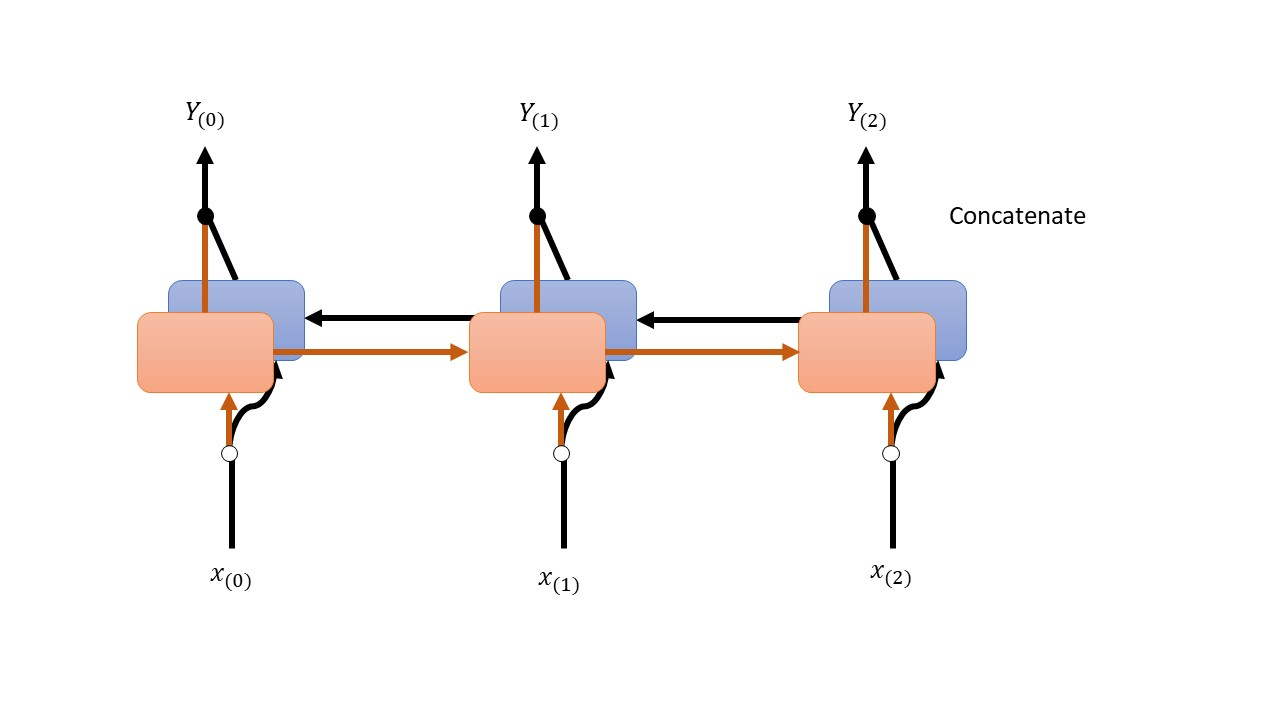

In keras we can use `keras.layers.Bidirectional`

In [ ]:
keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))

## Beam Search
I Natural Machine Translation task often the model fails to output the correct sentence just because of few words if previously outputted were incorrect and deliberately tries to correct the whole sentence by outputting relevant words against the previous output.

The question arise, How can we give the model a chance to go back and fix mistakes it made earlier?

The most common solution is *beam search*:<mark> it keeps track of a short list of the $k$ most promising sentences (say, the top three/four) and at each decoder step it tries to extend them by one word, keeping only the $k$ most likely sentences. The parameter  $k$ is calle the *beam width*.</mark>

Let's implement bean search using TensorFlow Addons:

In [ ]:
import tensorflow_addons as tfa

beam_width = 10
decoder = tfa.seq2seq.beam_search_decoder.BeamSearchDecoder(
    cell=decoder_cell, 
    beam_width=beam_width,
    output_layer=output_layer
)
decoder_initial_state = tfa.seq2seq.beam_search_decoder.tile_batch(
    encoder_state,
    multiplier=beam_width
)
outputs, _, _ = decoder(
    decoder_embeddings, 
    start_tokens=start_tokens,
    end_token=end_token,
    initial_state=decoder_initial_state 
)

This will give fairly good performance for short sentences but will fail short of gaining any reliable preformace when translating longer sentences due to limited short-term memory of RNNs. *Attention mechanisms* address this problem and provide a very good solution. Let's look at that how.

## Attention Mechanism
In our basic Encoder-Decoder setup a representation of word (along with other words) needs to be carried over many steps before it is actually used.

A revolutionary techniquee to make this path shorter was introduced in 2014 papaer by Dzmitry Bahdanau et a. <mark> They introduced a technique called concatenative attention (or *additive* or *Bahdanau* attention) that allowed the decoder to focus on the appropraite wwords (as encoded by encoder) at each time step.</mark>

**The idea behind concatenative attention**

The idea is to instead of just sending the encoder's final signal, we send all of its outuputs to the decoder. At each time step, the decoder's memory cell computes a weihted sum of all these encoder outputs: this determines which words it will focus on at this time step. 

>**The weight $\alpha_{(t,i)}$ is the weight of the i<sup>th</sup> encoder output at the t<sup>th</sup> decoder time step.** 

The rest of the decoder is same: the memory cell gets the input at each time step, the hidden state and (if training) target word from the previous step otherwise the output from the previous time step.

The weights $\alpha_{(t,i)}$ comes from *attention model* which consists of a time-distributed `Dense` layer with a single neuron, which recieves the encoder outputs, concatenated with decoder's previous hidden state which output a score (or energy) for each encoder output which finally goes through a softmax layer to get the weights for each encoder output.

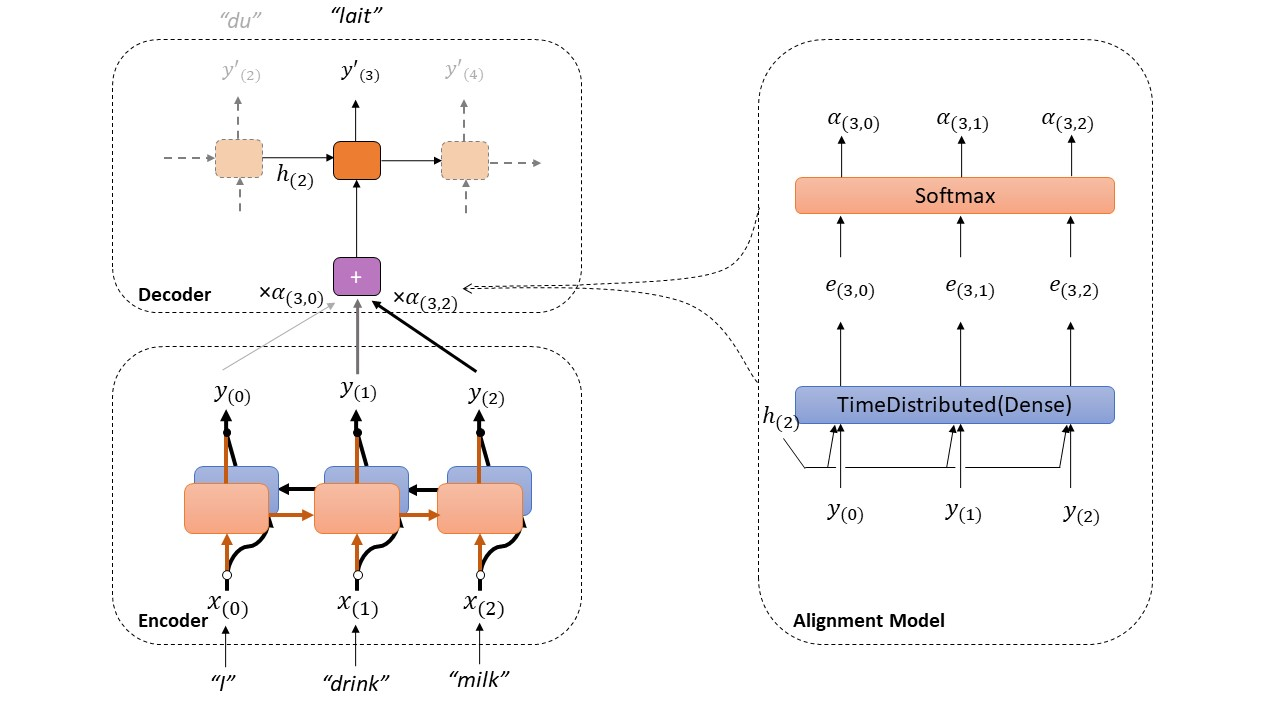

***Luong attention*** or ***Multiplicative attention***

A much more better performant attention mechanism was proposed by Ming-Thang Luong et al. in a 2015 paper.

**Simplifcation they proposed:**
- <mark>Since the goal of the attention mechanism is to measure the similarity between one of the encoder's outputs and the decoder's previous hidden state, the authors proposed to simply compute the *dot product* of these two vectors giving a score which all go though a softmax layer to get the final weights.</mark>
- Use the decoder's hidden state at the current time step ($h_{(t)}$) rather than previous time step ($h_{(t-1)}$), then to use the <mark>output of the attention mechanism ($\tilde{h}$)</mark> to compute decoder's predictions.

They also proposed "general" dot product approach where the encoder outputs first go through a linear transformations (i.e., a timie distributed `Dense`layer withouta bias term) before the dot products are computed.

*Equation 16-1. Attention Mechanism*
 $$\tilde{h}_{(t)} = \sum_i \alpha_{(t,i)}y_{(i)}$$

 with $\alpha_{(t,i)}=\frac{\exp\big(e_{(t,i)}\big)}{\sum_{i'}\exp\big( e_{(t, i')}\big)}$

  and $e_{(t, i)} = \begin{cases}h_{(t)}^\top y_{(i)}&\text{dot}\\h_{(t)}^\top Wy_{(i)}&\text{general}\\v^\top \tanh \big( W\big[h_{(t)};yy_{(i)}\big] \big)&\text{concat}\end{cases}$
  
Let's implement this using tensorflow-addons



In [ ]:
attention_mechanism = tfa.seq2seq.attention_wrapper.LuongAttention(
    units,
    encoder_state,
    memory_sequence_length=encoder_sequence_length,
)
attention_decoder = tfa.seq2seq.attention_wrapper.AttentionWrapper(
    decoder_cell,
    attention_mechanism,
    attenstion_layer_size=n_units
)

## Visual Attention
Another use case of attention mechanism is in generating image caption using visual attention.

A CNN is given a image which as usuak outputs feature maps, then a decoder RNN equipped with attention mechanism uses it to generates the caption by focussing on just the right part of the image; one word at a time.

## Attention Is All You Need: The Transformer Architecture
A team of Google researcher in 2017, released The Transformer architecture in their paper. A significantly faster to train and easier to parallelize; plus without any recurrent or convolutional layers, just attention mechanisms (plus few other things).

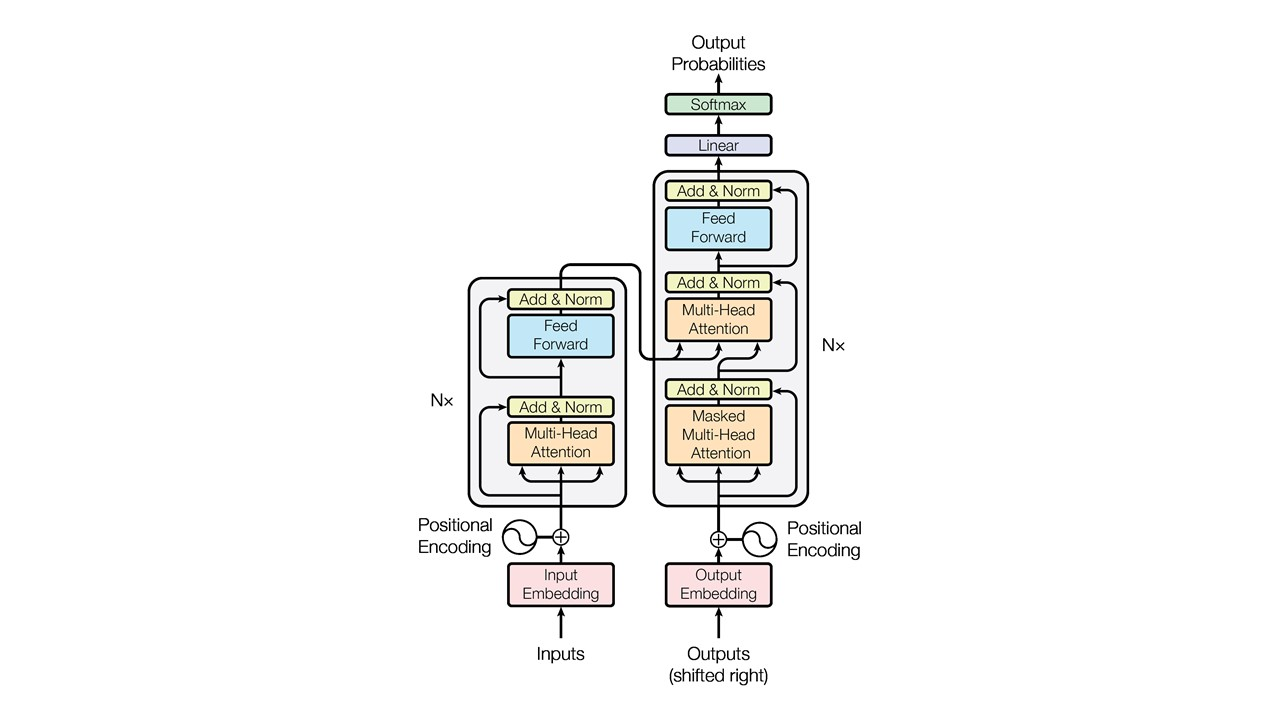

Image from [Papers with Code](https://paperswithcode.com/method/transformer)

**Let's dive in what's the diagram means:**
- Lefthand part is the encoder. Encodes each word into a 512-dimensional representation. The top part is stacked $N$ times.

  The input shape is `[batch_size, max_input_sentence_length]`  and the output shape becomes `[batch_size, max_input_sentence_length, 512]`. 
- Righthand part is the Decoder. During training, we inputs the target sentence (sequence of word IDs) shifted one time step to the right whereas at inference we feed it the previously output words.

  As with encoder; the top part part of decoder is also stacked $N$ times and each one recieves the final output of the encoder. The decoder outputs a probablity for each possible next word.
  
  At each time step (its output shape is `[batch_size, max_output_sentence_length, vocabulary_length]`.

The question arise then how do we translate a sentence by only looking at one word at a time?
- Encoder's ***Multi-Head Attention***: the purpose of this components is to <mark> encode each word's relationship with every other word in the same sentence, paying more attention to the most relevant ones, </mark> and relies on *self-attention* mechanism.
- Decoder's **Masked Multi-Head Attention*** does the same thing but each word is only allowed to attend to words located before it.
- ***Positional Embeddings*** <mark>are simply dense vectors that represent the position of a word in the sentence. The n<sup>th</sup> positional embedding is added to the word embeddings of the n<sup>th</sup> word in the sentence.</mark>




### Positional Embeddings
  
As said earlier it encodes the position of a word within a sentence. In the paper the authors preferred to use fixed positional embeddings as it can extend to arbitrarily long sentences. These are defined using sine and cosine functions of different frequencies. 

In the <mark>positional matrix $\mathbf{P}$</mark>; <mark>$P_{p, i}$ is the $i$<sup>th</sup> component of the embeddding for the word located at the $p$<sup>th</sup> position in the sentence.</mark>

*Equation 16-2. Sine/cosine positional embeddings*
 $$P_{p, 2i}=\sin\big(p/10000^{2i/d}\big)$$
 $$P_{p, 2i+1} = \cos \big( p/10000^{2i/d} \big)$$



In [6]:
class PositionalEmbedding(keras.layers.Layer):
  """
  max_steps: maximum sentence length
  max_dims: dimensions for each word represetation
  """
  def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
    super().__init__(dtype=dtype, **kwargs)
    if max_dims % 2 == 1: 
      max_dims +=1       # max_dims must be even
    p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims//2))
    pos_emb = np.empty((1, max_steps, max_dims))
    pos_emb[0, :, ::2] = np.sin(p / 10_000**(2 * i / max_dims)).T
    pos_emb[0, :, 1::2] = np.cos(p / 10_000**(2 * i / max_dims )).T
    self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))

  def call(self, inputs):
    shape= tf.shape(inputs)
    return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [7]:
embed_size = 512
max_steps = 500
vocab_size = 10_000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_embeddings = PositionalEmbedding(max_steps, max_dims=embed_size)
encoder_in = positional_embeddings(encoder_embeddings)
decoder_in = positional_embeddings(decoder_embeddings)

### Multi-Head Attention
To understand Multi-Head Attention layer works, we need to understand the ***Scaled Dot-Product Attention*** layer.

Suppose the decoder's already in the step to convert the verb from the input sentence, so it needs to fetch that verb in the original sentence. It's analgous to having the enocder creating a dictionary `{"subject": "They", "verb":"played", ...}`; the only thing tho is  the model does not have discrete tokens to repsent these keys instead it has vectorized representations of these concepts called the "query" which off course will not perfectly match any key in the dictionary.

The solution is to compute a similarity measure between the query and each key in the dictionary and then use the softmax function to convert these similarity scores to weights that add up to 1. If the kkey that repsents the verb is by far the most similar to the query, then that key's weight will be close to 1.

*Equation 14-3. Scaled Dot-Poduct Attention*
$$\text{Attention(Q,K,V)} = \text{softmax}\Big( \frac{\text{QK$^\top$}}{\sqrt{d_{keys}}}\Big)$$

In this equation:
- $\text{Q}$ matrix containing one row per query. Its shape is [$n_\text{queries}$, $d_\text{keys}$], where $n_\text{queries}$ is the number of queries and $d_\text{keys}$ is the number of dimensions of each query and each key.
- $\text{K}$ is a matrix containing one row per key. Its shape is [$n_\text{keys}$, $d_\text{keys}$], where $n_\text{keys}$ is the number of keys and values.
- $\text{V}$ is a matrix containing one row per value. Its shape is [$n_\text{keys}$, $n_\text{keys}$], it contains one similarity score for each query/key pair. The output of the softmax function has the same shape, but all rows sum up to 1. The final output has a shape of [$n_\text{queries}$, $d_\text{values}$], on row per query, each one represents the query result.

If we ignore the skip connections, layer normalization layers, the Feed Forward blcksm and the fact that this is a Scaled Dot prouct Attention, not exactly Multi-Head Attention, then the rest of the Transformer model can be implemented like this:

In [ ]:
Z = encoder_in
for N in range(6):
  Z = keras.layers.Attention(use_scale=True)([Z, z])                # use_scale=True: creates an additional
                                                                    # that lets the layer learn how to properly
encoder_outputs = Z                                                 # downscale the similarity scores. 
Z = decoder_in
for N in range(6):
  Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])   # causal = True: ensure each output 
  Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])  # token only attends to previous output
                                                                    # tokens, and not future ones
outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax")
)(Z)

So, What is Multi-Head Attention layer? This,

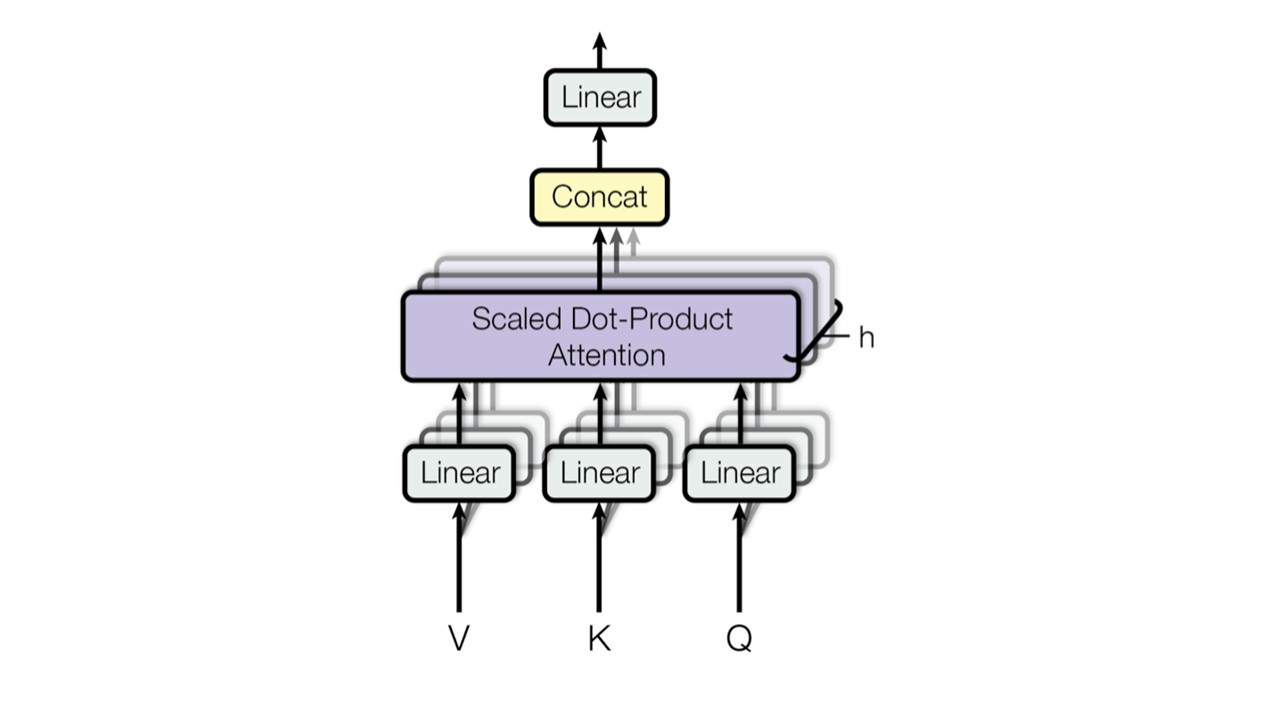

Image from [paperswithcode.com](https://www.google.com/url?sa=i&url=https%3A%2F%2Fpaperswithcode.com%2Fmethod%2Fmulti-head-attention&psig=AOvVaw1n8CQQ6jAkNEX-VqZcybOd&ust=1622902708189000&source=images&cd=vfe&ved=0CA0QjhxqFwoTCPj7su6V_vACFQAAAAAdAAAAABAD)

So a Multi-Head Attention layer is just a bunch of Scaled Dot Product Attention layers, each preceded by a linear transformation (Time distributed `Dense` layer with no activation) of the values, keys, and queries. The outputs are simply concatenated, and they go through a final linear transformation. But why tho?

The reason is <mark>the word representation encodes many different characteristics of the word. If we just used a single Scaled Dot Product Attention layer, we wouldn't be able to query all of these characteristics. This is why Multi-Head Attention layer applies multiple different linear transformations of the values, keys, and queries: this allow the model to apply many different projections of the word representation into different subpaces, each focusing on a subset of the word's characteristics.</mark>